### Necessary Imports and Installs

In [1]:
# !pip install -U tensorflow-addons
# !pip install huggingface-hub
# !pip install transformers

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Conv2D, Dense, AveragePooling2D, BatchNormalization, Dropout, Flatten, Lambda, Input, Activation
from tensorflow.keras import Model
from tensorflow.keras.optimizers import schedules, SGD
from tensorflow.keras.callbacks import Callback, TensorBoard as TensorboardCallback, EarlyStopping
from tensorflow.keras import backend as K

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from huggingface_hub import notebook_login, HfFolder, HfApi

from transformers import TFViTForImageClassification, create_optimizer, ViTFeatureExtractor

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import scale
import time
from collections import defaultdict
import math
import copy
import opendatasets as od
# import cartopy

%pylab inline --no-import-all
from pathlib import Path
import pandas as pd
import sys

Populating the interactive namespace from numpy and matplotlib


## Load Dataset from file

In [2]:
# Change this path to adapt to where you downloaded the data
DATA_PATH = Path("./geolifeclef-2022-lifeclef-2022-fgvc9/")

In [3]:
import time
hours = 4
#time.sleep(60*60*hours)

In [4]:
### Training Dataset ###
# let's load the data from file
df_obs_fr = pd.read_csv(DATA_PATH / "observations" / "observations_fr_train.csv", sep=";", index_col="observation_id")
df_obs_us = pd.read_csv(DATA_PATH / "observations" / "observations_us_train.csv", sep=";", index_col="observation_id")

df_obs = pd.concat((df_obs_fr, df_obs_us))

print("Number of observations for training: {}".format(len(df_obs)))

# let's have a look at the data
df_obs.head()

Number of observations for training: 1627475


,latitude,longitude,species_id,subset
observation_id,,,,
10561949,45.705116,1.424622,241,train
10131188,45.146973,6.416794,101,train
10799362,46.783695,-2.072855,700,train
10392536,48.604866,-2.825003,1456,train
10335049,48.815567,-0.161431,157,train


In [5]:
### Test Dataset ###
df_obs_fr_test = pd.read_csv(DATA_PATH / "observations" / "observations_fr_test.csv", sep=";", index_col="observation_id")
df_obs_us_test = pd.read_csv(DATA_PATH / "observations" / "observations_us_test.csv", sep=";", index_col="observation_id")

df_obs_test = pd.concat((df_obs_fr_test, df_obs_us_test))

print("Number of observations for testing: {}".format(len(df_obs_test)))

df_obs_test.head()

Number of observations for testing: 36421


,latitude,longitude
observation_id,,
10782781,43.601788,6.940195
10364138,46.241711,0.683586
10692017,45.181095,1.533459
10222322,46.938450,5.298678
10241950,45.017433,0.960736


In [6]:
df_suggested_landcover_alignment = pd.read_csv(DATA_PATH / "metadata" / "landcover_suggested_alignment.csv", sep=";")
df_suggested_landcover_alignment.head()

,landcover_code,suggested_landcover_code,suggested_landcover_label
0,0,0,Missing Data
1,1,11,Cultivated Crops
2,2,11,Cultivated Crops
3,3,6,Broad-leaved Forest
4,4,7,Coniferous Forest


In [7]:
from GLC.data_loading.common import load_patch

patch = load_patch(10171444, DATA_PATH)

print("Number of data sources: {}".format(len(patch)))
print("Arrays shape: {}".format([p.shape for p in patch]))
print("Data types: {}".format([p.dtype for p in patch]))

Number of data sources: 4
Arrays shape: [(256, 256, 3), (256, 256), (256, 256), (256, 256)]
Data types: [dtype('uint8'), dtype('uint8'), dtype('int16'), dtype('uint8')]


In [8]:
landcover_mapping = df_suggested_landcover_alignment["suggested_landcover_code"].values
#patch = load_patch(10171444, DATA_PATH, landcover_mapping=landcover_mapping)

In [9]:
# from GLC.plotting import visualize_observation_patch

# # Extracts land cover labels
# landcover_labels = df_suggested_landcover_alignment[["suggested_landcover_code", "suggested_landcover_label"]].drop_duplicates().sort_values("suggested_landcover_code")["suggested_landcover_label"].values

# visualize_observation_patch(patch, observation_data=df_obs.loc[10561900], landcover_labels=landcover_labels)

In [10]:
"""patch = load_patch(22068100, DATA_PATH, landcover_mapping=landcover_mapping)

visualize_observation_patch(patch, observation_data=df_obs.loc[22068100], landcover_labels=landcover_labels)
"""

'patch = load_patch(22068100, DATA_PATH, landcover_mapping=landcover_mapping)\n\nvisualize_observation_patch(patch, observation_data=df_obs.loc[22068100], landcover_labels=landcover_labels)\n'

### Train/Val Split Labels
Retrieve the train/val split provided.

In [11]:
obs_id_train = df_obs.index[df_obs["subset"] == "train"].values
obs_id_val = df_obs.index[df_obs["subset"] == "val"].values

y_train = df_obs.loc[obs_id_train]["species_id"].values
y_val = df_obs.loc[obs_id_val]["species_id"].values

n_val = len(obs_id_val)
print("Training set size: {} ({:.1%} of train observations)".format(len(y_train), len(y_train) / len(df_obs)))
print("Validation set size: {} ({:.1%} of train observations)".format(n_val, n_val / len(df_obs)))

Training set size: 1587395 (97.5% of train observations)
Validation set size: 40080 (2.5% of train observations)


### Load patches

In [21]:
# load training dataset samples
# factor = 1 means load full training dataset
# factor = 100 means load 1/100 of the full dataset
factor = 100

X_train = list() #np.array((np.shape(y_train), 256, 256, 3))
for obs_id in obs_id_train:
    patch = load_patch(obs_id, DATA_PATH, landcover_mapping=landcover_mapping)
    X_train.append(patch[0])
    
    percent_progress = len(X_train)/(len(y_train)/factor) * 100
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("[%-20s] %d%%" % ('='*int(percent_progress/5), percent_progress))
    sys.stdout.flush()
        
    if len(X_train) >= (len(y_train)/factor):
        break
print()
    
X_train = np.array(X_train)

[====================] 100%


In [22]:
print(sys.getsizeof(X_train) / 1_000_000, "MB")

3120.955536 MB


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train[:len(X_train)]))
train_ds = train_ds.batch(64)

In [23]:
# load validation dataset samples
factor = 10

X_val = list() #np.array((np.shape(y_train), 256, 256, 3))
for obs_id in obs_id_val:
    patch = load_patch(obs_id, DATA_PATH, landcover_mapping=landcover_mapping)
    X_val.append(patch[0])
    
    percent_progress = len(X_val)/(len(y_val)/factor) * 100
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("[%-20s] %d%%" % ('='*int(percent_progress/5), percent_progress))
    sys.stdout.flush()
    
    if len(X_val) >= (len(y_val)/factor):
        break

print()
    
X_val = np.array(X_val)

[====================] 100%


In [24]:
num_classes = len(set(df_obs['species_id']))
input_shape = (256, 256, 3)

print(f"X_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape} - y_test shape: {y_val.shape}")

X_train shape: (15874, 256, 256, 3) - y_train shape: (1587395,)
X_val shape: (4008, 256, 256, 3) - y_test shape: (40080,)


In [25]:
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val[:len(X_val)]))
val_ds = val_ds.batch(64)

2022-04-23 21:42:03.958682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 21:42:03.959435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 21:42:04.096240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 21:42:04.096945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 21:42:04.097632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## Preprocess

# Transformer - ViT - from scratch

In [26]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [27]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# multi-layer perceptron
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Patch creation
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


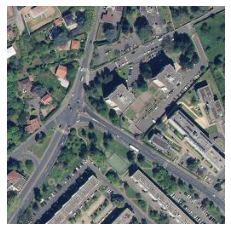

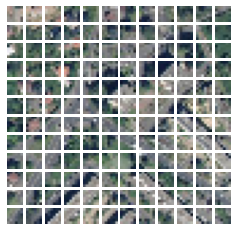

In [28]:
# Visualize patches
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [29]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [30]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        X_train, y_train[:len(X_train)],
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=val_ds,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
#     _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
#     print(f"Test accuracy: {round(accuracy * 100, 2)}%")
#     print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/50
63/63 [==============================] - 38s 441ms/step - loss: 8.1912 - accuracy: 0.0014 - top-5-accuracy: 0.0074 - val_loss: 7.8229 - val_accuracy: 0.0017 - val_top-5-accuracy: 0.0090
Epoch 2/50
63/63 [==============================] - 31s 486ms/step - loss: 7.5367 - accuracy: 0.0020 - top-5-accuracy: 0.0076 - val_loss: 7.5224 - val_accuracy: 0.0030 - val_top-5-accuracy: 0.0122
Epoch 3/50
63/63 [==============================] - 31s 485ms/step - loss: 7.4143 - accuracy: 0.0023 - top-5-accuracy: 0.0097 - val_loss: 7.4610 - val_accuracy: 0.0032 - val_top-5-accuracy: 0.0097
Epoch 4/50
63/63 [==============================] - 27s 422ms/step - loss: 7.3606 - accuracy: 0.0023 - top-5-accuracy: 0.0110 - val_loss: 7.4469 - val_accuracy: 0.0030 - val_top-5-accuracy: 0.0092
Epoch 5/50
63/63 [==============================] - 27s 425ms/step - loss: 7.2836 - accuracy: 0.0036 - top-5-accuracy: 0.0142 - val_loss: 7.4264 - val_accuracy: 0.0027 - val_top-5-accuracy: 0.0127
Epoch 6/50
63/6

KeyboardInterrupt: 

In [ ]:
vit_classifier.summary()

# Transformer - ViT - pre-trained

In [31]:
notebook_login()

Login successful
Your token has been saved to /home/jjw2196/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [32]:
model_id = "google/vit-base-patch16-224-in21k"

In [33]:
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# learn more about data augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation
data_augmentation = keras.Sequential(
    [
        layers.Resizing(feature_extractor.size, feature_extractor.size),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# use keras image data augementation processing
# def augmentation(examples):
#     # print(examples["img"])
#     examples["pixel_values"] = [data_augmentation(image) for image in examples["img"]]
#     return examples


# basic processing (only resizing)
def process(examples):
    examples.update(feature_extractor(examples['img'], ))
    return examples

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [34]:
num_train_epochs = 5
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_id.split("/")[1]
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
hub_model_id = f'{model_id.split("/")[1]}-species-prediction'
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
    keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


2022-04-23 21:54:22.300024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 21:54:22.300654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [29]:
# create optimizer wight weigh decay
num_train_steps = len(train_ds) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
base_model = TFViTForImageClassification.from_pretrained(
    model_id,
    num_labels=num_classes,
)

# Inputs
inputs = layers.Input(shape=input_shape)

# Augment data.
augmented = data_augmentation(inputs)

# Pre-trained ViT model
vit = base_model.vit(augmented)[0]

# Add classification head
classifier = tf.keras.layers.Dense(num_classes, activation='softmax', name='outputs')(vit[:, 0, :])

model = tf.keras.Model(inputs=inputs, outputs=classifier)

# Optimizer
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, 
                                 weight_decay=weight_decay)
# Compile model
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[
                  tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(10, name="top-10-accuracy")
              ]
              )

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: in user code:

    /home/ecbm4040/envTF24/lib/python3.6/site-packages/transformers/modeling_tf_utils.py:493 run_call_with_unpacked_inputs  *
        return func(self, **unpacked_inputs)
    /home/ecbm4040/envTF24/lib/python3.6/site-packages/transformers/models/vit/modeling_tf_vit.py:494 call  *
        embedding_output = self.embeddings(
    /home/ecbm4040/envTF24/lib/python3.6/site-packages/transformers/models/vit/modeling_tf_vit.py:123 call  *
        embeddings = self.patch_embeddings(
    /home/ecbm4040/envTF24/lib/python3.6/site-packages/transformers/models/vit/modeling_tf_vit.py:189 call  *
        projection = self.projection(pixel_values)
    /home/ecbm4040/envTF24/lib/python3.6/site-packages/keras/engine/base_layer.py:1020 __call__  **
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/ecbm4040/envTF24/lib/python3.6/site-packages/keras/engine/input_spec.py:254 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer projection is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape (None, 224, 3, 224)


In [ ]:
callbacks=[]

callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))
callbacks.append(EarlyStopping(monitor="val_accuracy",patience=1))
if hub_token:
    callbacks.append(PushToHubCallback(output_dir=output_dir,
                                       hub_model_id=hub_model_id,
                                       hub_token=hub_token))

In [ ]:
train_results = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=num_train_epochs,
)

In [ ]:
api = HfApi()

user = api.whoami(hub_token)

feature_extractor.save_pretrained(output_dir)

api.upload_file(
    token=hub_token,
    repo_id=f"{user['name']}/{hub_model_id}",
    path_or_fileobj=os.path.join(output_dir,"preprocessor_config.json"),
    path_in_repo="preprocessor_config.json",
)

# First Simple Neural Network
Let's create a first neural network as a baseline to see how it performs.

In [ ]:
# returns a 10 layer ReLU model of width 2
def simple_model(input_shape):
    model = tf.keras.models.Sequential()
    
    # 1. Preprocessing
    # rescale inputs
    model.add(tf.keras.layers.Rescaling(1./255))

    # 2. Convolutional Layers
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=input_shape, padding='same'))
    #model.add(AveragePooling2D())

    model.add(Conv2D(64, kernel_size=5, activation='relu', padding='same'))
    #model.add(AveragePooling2D())
    
    model.add(Conv2D(128, kernel_size=5, activation='relu', padding='same'))
    
    # from convolutional layers to dense layers
    model.add(tf.keras.layers.Flatten())
    
    # 3. Dense Layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    
    # 4. Output Layer
    model.add(Dense(4911, activation='softmax'))
    
    # compire the model
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    
    return model

In [ ]:
# create the network
model = simple_model((256, 256, 3))

In [ ]:
np.max(y_train[:len(X_train)])

In [ ]:
np.min(y_train[:len(X_train)])

Train the network.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0.001, patience=5, 
                                              verbose=0, mode='auto', baseline=None, restore_best_weights=True)


In [ ]:
history = model.fit(train_ds, validation_data=val_ds, #X_train, y_train[:len(X_train)], #validation_data=(X_val, y_val), 
                    epochs=100, 
                    callbacks=[early_stop])

In [ ]:
model.save('first_simple_model')